In [1]:
%env  WORKDIR=/tmp/vault

env: WORKDIR=/tmp/vault


In [2]:
%%bash
cat ${WORKDIR}/cluster-keys.json | jq -r ".root_token"

hvs.kABdKt9HrZusmhHhIbqQSB8W


In [3]:
%env VAULT_ADDR=https://127.0.0.1:8200
%env VAULT_TOKEN=hvs.kABdKt9HrZusmhHhIbqQSB8W
%env VAULT_CACERT=/tmp/vault/vault.ca

env: VAULT_ADDR=https://127.0.0.1:8200
env: VAULT_TOKEN=hvs.kABdKt9HrZusmhHhIbqQSB8W
env: VAULT_CACERT=/tmp/vault/vault.ca


## Enable LDAP Secret Engine

In [4]:
%%bash
vault secrets enable ldap

Success! Enabled the ldap secrets engine at: ldap/


## Connect to LDAP with username (bindDN) and password

In [5]:
%%bash
vault write ldap/config \
    binddn=cn=admin,dc=learn,dc=example \
    bindpass=2LearnVault \
    url=ldap://openldap:389


Success! Data written to: ldap/config


## Create a Role (Static Role)

In [6]:
%%bash
# Automatic Rotation
vault write ldap/static-role/learn \
    dn='cn=serviceaccount,ou=users,dc=learn,dc=example' \
    username='serviceaccount' \
    rotation_period="1h"


Success! Data written to: ldap/static-role/learn


## Request credential via CLI

In [7]:
%%bash
vault read ldap/static-cred/learn

Key                    Value
---                    -----
dn                     cn=serviceaccount,ou=users,dc=learn,dc=example
last_password          n/a
last_vault_rotation    2023-05-25T15:11:52.259570002Z
password               HQZ4bS8tvEYqVu8f5ISnOpK5FKldphGzITCp9JWkVoNjk92vtjqk8APzoudJGQST
rotation_period        1h
ttl                    59m55s
username               serviceaccount


## Request credential via API

In [9]:
%%bash
curl -k \
    --header "X-Vault-Token: $VAULT_TOKEN" \
    --request GET \
    --silent \
    $VAULT_ADDR/v1/ldap/static-cred/learn | jq . -r


{
  "request_id": "d6e8e704-e4d0-c858-17ad-971b46ae423b",
  "lease_id": "",
  "renewable": false,
  "lease_duration": 0,
  "data": {
    "dn": "cn=serviceaccount,ou=users,dc=learn,dc=example",
    "last_password": "",
    "last_vault_rotation": "2023-05-25T15:11:52.259570002Z",
    "password": "HQZ4bS8tvEYqVu8f5ISnOpK5FKldphGzITCp9JWkVoNjk92vtjqk8APzoudJGQST",
    "rotation_period": 3600,
    "ttl": 3544,
    "username": "serviceaccount"
  },
  "wrap_info": null,
  "warnings": null,
  "auth": null
}


In [ ]:
%%bash
vault read ldap/static-cred/learn
# Credetials are rotated in a lazy manner, ttl gets reduced, once it comes to 0 with the next request credential are rotated

In [10]:
%%bash
# Manual rotation
vault write -f ldap/rotate-role/learn

Success! Data written to: ldap/rotate-role/learn


In [11]:
%%bash
vault read ldap/static-cred/learn
# Credetials are rotated in a lazy manner, ttl gets reduced, once it comes to 0 with the next request credential are rotated

Key                    Value
---                    -----
dn                     cn=serviceaccount,ou=users,dc=learn,dc=example
last_password          HQZ4bS8tvEYqVu8f5ISnOpK5FKldphGzITCp9JWkVoNjk92vtjqk8APzoudJGQST
last_vault_rotation    2023-05-25T15:13:02.590264132Z
password               kkRrmCu4Od4PKZCXwfSqCbYmznSJbH3aOFDsErId4d0y2mJVclA4mNPqA3VrdZYI
rotation_period        1h
ttl                    59m57s
username               serviceaccount


## Connecting to LDAP with the static role password

In [12]:
%%bash
LDAP_PASSWORD=$(vault read --format=json ldap/static-cred/learn | jq -r ".data.password")
ldapsearch -p 1389 -h 127.0.0.1 -b "cn=serviceaccount,ou=users,dc=learn,dc=example" \
    -D 'cn=serviceaccount,ou=users,dc=learn,dc=example' \
    -w $LDAP_PASSWORD

# extended LDIF
#
# LDAPv3
# base <cn=serviceaccount,ou=users,dc=learn,dc=example> with scope subtree
# filter: (objectclass=*)
# requesting: ALL
#

# serviceaccount, users, learn.example
dn: cn=serviceaccount,ou=users,dc=learn,dc=example
objectClass: person
objectClass: top
sn: serviceaccount
cn: serviceaccount
userPassword:: a2tScm1DdTRPZDRQS1pDWHdmU3FDYlltem5TSmJIM2FPRkRzRXJJZDRkMHkybUp
 WY2xBNG1OUHFBM1ZyZFpZSQ==

# search result
search: 2
result: 0 Success

# numResponses: 2
# numEntries: 1


## Dynamic Credentials

In [13]:
%%bash
cat > ${WORKDIR}/creation.ldif <<EOF
dn: uid={{.Username}},ou=users,dc=learn,dc=example
objectClass: inetOrgPerson
uid: {{.Username}}
cn: {{.Username}}
sn: {{.Username}}
userPassword: {{.Password}}
EOF

In [14]:
%%bash
cat > ${WORKDIR}/deletion_rollback.ldif <<EOF
dn: uid={{.Username}},ou=users,dc=learn,dc=example
changetype: delete
EOF

In [15]:
%%bash
# Dynamic Role
vault write ldap/role/dynamic \
     creation_ldif=@${WORKDIR}/creation.ldif \
     deletion_ldif=@${WORKDIR}/deletion_rollback.ldif \
     rollback_ldif=@${WORKDIR}/deletion_rollback.ldif \
     default_ttl=1h

Success! Data written to: ldap/role/dynamic


In [16]:
%%bash
vault read ldap/creds/dynamic

Key                    Value
---                    -----
lease_id               ldap/creds/dynamic/OrdIRwfUjyLdguTJ9kKyGj2c
lease_duration         1h
lease_renewable        true
distinguished_names    [uid=v_root_dynamic_bsmTqEKQ0y_1685027654,ou=users,dc=learn,dc=example]
password               veYjVxEEZIGNpA1ikr5agNU1vScncTawR1g0vJlSr0ycLpZ3P2bZtFdo6AMqwtCR
username               v_root_dynamic_bsmTqEKQ0y_1685027654


In [17]:
%%bash
curl -k --header "X-Vault-Token: $VAULT_TOKEN" --request GET --silent $VAULT_ADDR/v1/ldap/creds/dynamic | jq

{
  "request_id": "d5e90895-50d3-1933-bf05-e1473b4fb2fd",
  "lease_id": "ldap/creds/dynamic/Npq5DFdfmo62xqDFLZBoAFyp",
  "renewable": true,
  "lease_duration": 3600,
  "data": {
    "distinguished_names": [
      "uid=v_root_dynamic_ncn7P21DJi_1685027664,ou=users,dc=learn,dc=example"
    ],
    "password": "s8afJHM3H45hUqfSqjJTo5E9sDS4bHgPlSzEagpXXpgjOs9vLyS1EK3PSquaEYLf",
    "username": "v_root_dynamic_ncn7P21DJi_1685027664"
  },
  "wrap_info": null,
  "warnings": null,
  "auth": null
}


In [18]:
%%bash
curl -k \
    --header "X-Vault-Token: $VAULT_TOKEN" \
    --request GET \
    --silent \
    $VAULT_ADDR/v1/ldap/creds/dynamic \
    | jq . -r

{
  "request_id": "e24ea14d-02f0-ceeb-6f35-69638ca1fd06",
  "lease_id": "ldap/creds/dynamic/YUVVl6XsTWmYqoqmv6jYdgZz",
  "renewable": true,
  "lease_duration": 3600,
  "data": {
    "distinguished_names": [
      "uid=v_root_dynamic_HgRm25abO0_1685027669,ou=users,dc=learn,dc=example"
    ],
    "password": "UfP3P3WSZ8go5LPdRL0VtD38yyOrrd30QHtpUnm7QMbwqsYtzxXw8NxqnqDyIitr",
    "username": "v_root_dynamic_HgRm25abO0_1685027669"
  },
  "wrap_info": null,
  "warnings": null,
  "auth": null
}


## Lista de cuentas dinámicas creadas

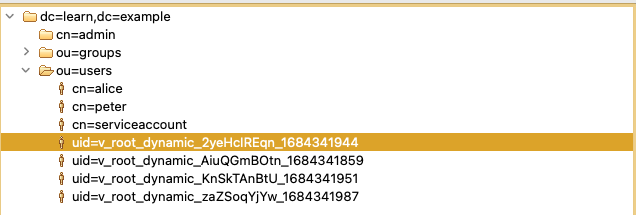

In [19]:
%%bash
## Check leases in Vault
vault list sys/leases/lookup/ldap/creds/dynamic

Keys
----
Npq5DFdfmo62xqDFLZBoAFyp
OrdIRwfUjyLdguTJ9kKyGj2c
YUVVl6XsTWmYqoqmv6jYdgZz


In [20]:
%%bash
## Revoke individual token
vault lease revoke ldap/creds/dynamic/\
$(vault list -format=json sys/leases/lookup/ldap/creds/dynamic | jq -r .[0])
vault list sys/leases/lookup/ldap/creds/dynamic

All revocation operations queued successfully!
Keys
----
OrdIRwfUjyLdguTJ9kKyGj2c
YUVVl6XsTWmYqoqmv6jYdgZz


In [21]:
%%bash
## Elimino todas las cuentas creadas
vault lease revoke -prefix ldap/creds/dynamic

All revocation operations queued successfully!
